In [423]:
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

In [424]:
n_samples = 100
n_classes = 4
epsilon = 0.05

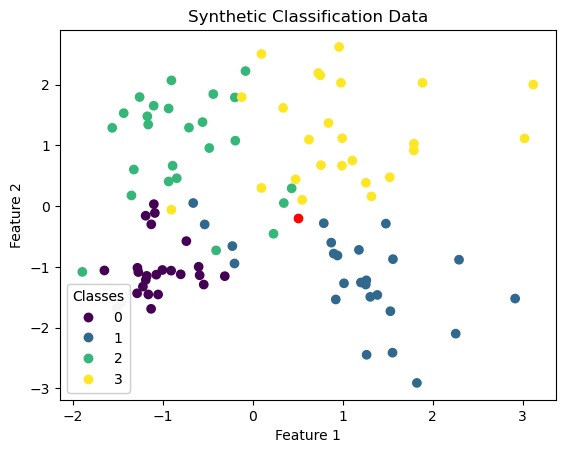

In [425]:
X,y = make_classification(n_samples=n_samples,
                          n_classes=n_classes,
                          n_features=2,
                          n_informative=2,
                          n_redundant=0,
                          n_clusters_per_class=1,
                          random_state=31)
x_new = np.array([0.5,-0.2])

fig,ax = plt.subplots()

ax.set_title("Synthetic Classification Data")

scatter = ax.scatter(X[:,0],X[:,1],c=y)
ax.scatter(*x_new,c='r')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
ax.add_artist(legend1)

ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
plt.show()

An example of a nonconformity score based on the $k$ nearest neighbors:
$$
f(\vec{x},y) = \frac{\sum_{i=1}^k d_i^+}{\sum_{i=1}^k d_i^-}
$$
where $d_i^+$ is the distance from the $i^{th}$ nearest neighbor labeled y, and $d_i^-$ the distance from the $i^{th}$ nearest neighbor labeled differently.

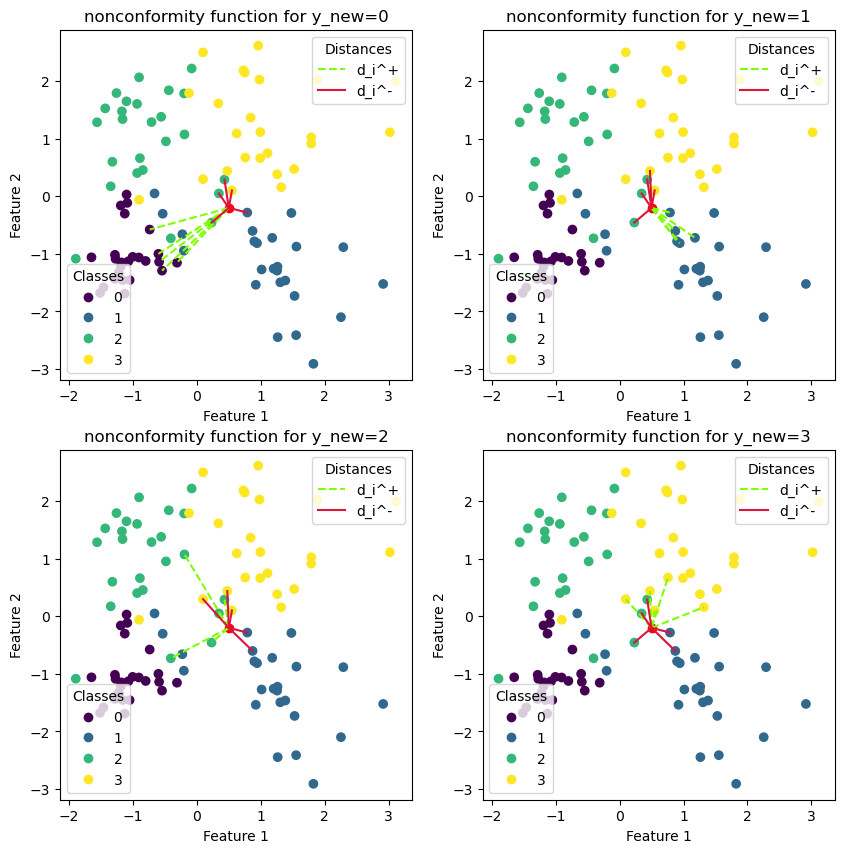

In [426]:
def euclidean_distance(x, data):
    dist = np.linalg.norm(
        x - data, axis=1, ord=2
    )  # L2-norm (euclidean distance between x and all data points in X)
    return dist

def nearest_neighbors_idx(distances, k=5):
    idx = np.argpartition(
        distances, k
    )  # makes the kth element as pivot such that left from it are all smaller elements
    return idx[:k]

def nearest_neighbors_distance(x, data, k=5):
    dist = euclidean_distance(x,data)
    idx = nearest_neighbors_idx(dist,k)
    return dist[idx] # get the distances of the k nearest neighbors

def split_data_classes(y_i,X,y):
    # create two datasets one where each point has the same class as y_i the other points in the second dataset.
    mask_same_class = y == y_i
    data_with_same_class = X[mask_same_class, :]
    data_with_other_class = X[~mask_same_class, :]
    return data_with_same_class, data_with_other_class

def nonconformity_function(x_i, y_i, X, y):
    data_with_same_class, data_with_other_class = split_data_classes(y_i, X, y)
    distance_to_same_class = np.sum(
        nearest_neighbors_distance(x_i, data_with_same_class, k=5)
    )
    distance_to_other_class = np.sum(
        nearest_neighbors_distance(x_i, data_with_other_class, k=5)
    )

    return distance_to_same_class / distance_to_other_class

def plot_nearest_neighbors_distance(y_new,ax):
    ax.set_title(f"nonconformity function for y_new={y_new}")

    scatter = ax.scatter(X[:, 0], X[:, 1], c=y)
    ax.scatter(*x_new, c='red')

    # visualize the distance to the equally labeled points:
    data_with_same_class, data_with_other_class = split_data_classes(y_new,X,y)
    for i in nearest_neighbors_idx(euclidean_distance(x_new,data_with_same_class),k=5):
        x_values =[x_new[0],data_with_same_class[i,0]]
        y_values = [x_new[1], data_with_same_class[i, 1]]
        line1, = ax.plot(x_values,y_values, linestyle="--",c='chartreuse',label="d_i^+")

    # visualize the distance to the differently labeled points:
    for i in nearest_neighbors_idx(euclidean_distance(x_new, data_with_other_class), k=5):
        x_values = [x_new[0], data_with_other_class[i, 0]]
        y_values = [x_new[1], data_with_other_class[i, 1]]
        line2, = ax.plot(x_values, y_values, linestyle="-", c="crimson",label="d_i^-")

    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
    ax.add_artist(legend1)

    # produce a legend with the distance
    ax.legend(handles=[line1,line2], loc="upper right", title="Distances")

    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

fig, axes = plt.subplots(2,2)
fig.set_size_inches(10, 10)
plot_nearest_neighbors_distance(y_new=0, ax=axes[0,0])
plot_nearest_neighbors_distance(y_new=1, ax=axes[0, 1])
plot_nearest_neighbors_distance(y_new=2, ax=axes[1, 0])
plot_nearest_neighbors_distance(y_new=3, ax=axes[1, 1])
plt.show()

In [427]:
def get_nonconformityScores(x_new,y_new):
    data = np.concatenate((X,y.reshape(-1,1)),axis=1) # merge X and y into one array
    new_point = np.hstack((x_new,y_new)) # make the new data point
    complete_data = np.vstack((data,new_point)) # put all together
    
    resulting_scores = np.array([
        nonconformity_function(x_i = complete_data[i,:-1],
                               y_i = complete_data[i,-1],
                               X=np.delete(complete_data,i,axis=0)[:,:-1],
                               y=np.delete(complete_data,i,axis=0)[:,-1]
                               )
        for i in range(complete_data.shape[0])
    ])
    
    return resulting_scores
    #print(complete_data)

def calculate_probability(nonconformity_sequence):
    # calculate the proportion that atleast the new datapoints nonconformity score occurs.
    new_datapoint_nonconformityScore = nonconformity_sequence[-1]
    probability = np.sum(
        nonconformity_sequence >= new_datapoint_nonconformityScore
    ) / len(
        nonconformity_sequence
    )  # the N + 1 is inherently in the length of the sequence
    return probability



In [428]:
Y_hat = np.array(
    [
        i
        for i in range(n_classes)
        if calculate_probability(get_nonconformityScores(x_new, i)) >= 0.05
    ]
)
print(Y_hat)

[1 2 3]
